In [33]:
import numpy as np
import sys
import os
import pandas as pd

# Adjust the path to point to external/AlphaPEM
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from src.sampling.sampler import get_polarisation_curve_samples, build_fixed_parameters, sample_parameters, PARAMETER_RANGES

In [34]:
def make_bounds_exclusive(bounds, epsilon=1e-8):
    return [(low + epsilon, high - epsilon) for (low, high) in bounds]

def prepare_problem(PARAMETER_RANGES, dependent_param="Pc_des"):
    independent_params = {
        k: v for k, v in PARAMETER_RANGES.items()
        if k != dependent_param
    }
    # Add dummy variable to later compute dependent_param
    z_key = f"z_{dependent_param}"
    independent_params[z_key] = (0, 1)

    bounds = [v if isinstance(v, tuple) else [min(v), max(v)] for v in independent_params.values()]
    bounds = make_bounds_exclusive(bounds)

    problem = {
        "num_vars": len(independent_params),
        "names": list(independent_params.keys()),
        "bounds": bounds,
        "groups": list(independent_params.keys())  # optional but useful for group-based SA
    }
    return problem

problem = prepare_problem(PARAMETER_RANGES)

In [35]:
from SALib.sample import morris
from SALib.analyze import morris as morris_analyze
import random

def generate_samples(problem, N=2, num_levels=4, seed=42):
    np.random.seed(seed)
    random.seed(seed)
    samples = morris.sample(problem, N=N, num_levels=num_levels)
    return pd.DataFrame(samples, columns=problem["names"])

def compute_dependent_param(df_samples, param_name="Pc_des", Pext=101325):
    z_key = f"z_{param_name}"
    Pa_des = df_samples["Pa_des"]
    z = df_samples[z_key]

    low = np.maximum(Pext, Pa_des - 0.5e5)
    high = np.maximum(Pext, Pa_des - 0.1e5)

    df_samples[param_name] = low + z * (high - low)
    df_samples = df_samples.drop(columns=z_key)
    return df_samples, low, high

df_samples = generate_samples(problem)
df_samples, low, high = compute_dependent_param(df_samples)

In [36]:
results = pd.read_pickle("../data/raw/results.pkl")

In [37]:
def replace_z_with_actual_param(problem, low, high, param_name="Pc_des"):
    z_key = f"z_{param_name}"
    idx = problem["names"].index(z_key)
    problem["names"][idx] = param_name
    problem["bounds"][idx] = (low.min(), high.max())
    problem["groups"][idx] = param_name
    return problem

problem = replace_z_with_actual_param(problem, low, high)

In [38]:
def run_morris_analysis(df_samples, problem, results, output_key='Ucell', num_levels=4):
    Y_all = np.stack(results[output_key].values)
    n_outputs = Y_all.shape[1]

    morris_all = []
    for i in range(n_outputs):
        analysis = morris_analyze.analyze(
            problem=problem,
            X=df_samples.to_numpy(),
            Y=Y_all[:, i],
            conf_level=0.95,
            num_levels=num_levels,
            print_to_console=False
        )
        morris_all.append({
            'mu_star': analysis['mu_star'],
            'sigma': analysis['sigma'],
            'param': problem['names'],
            'output_index': i
        })
    return morris_all

morris_all = run_morris_analysis(df_samples, problem, results)


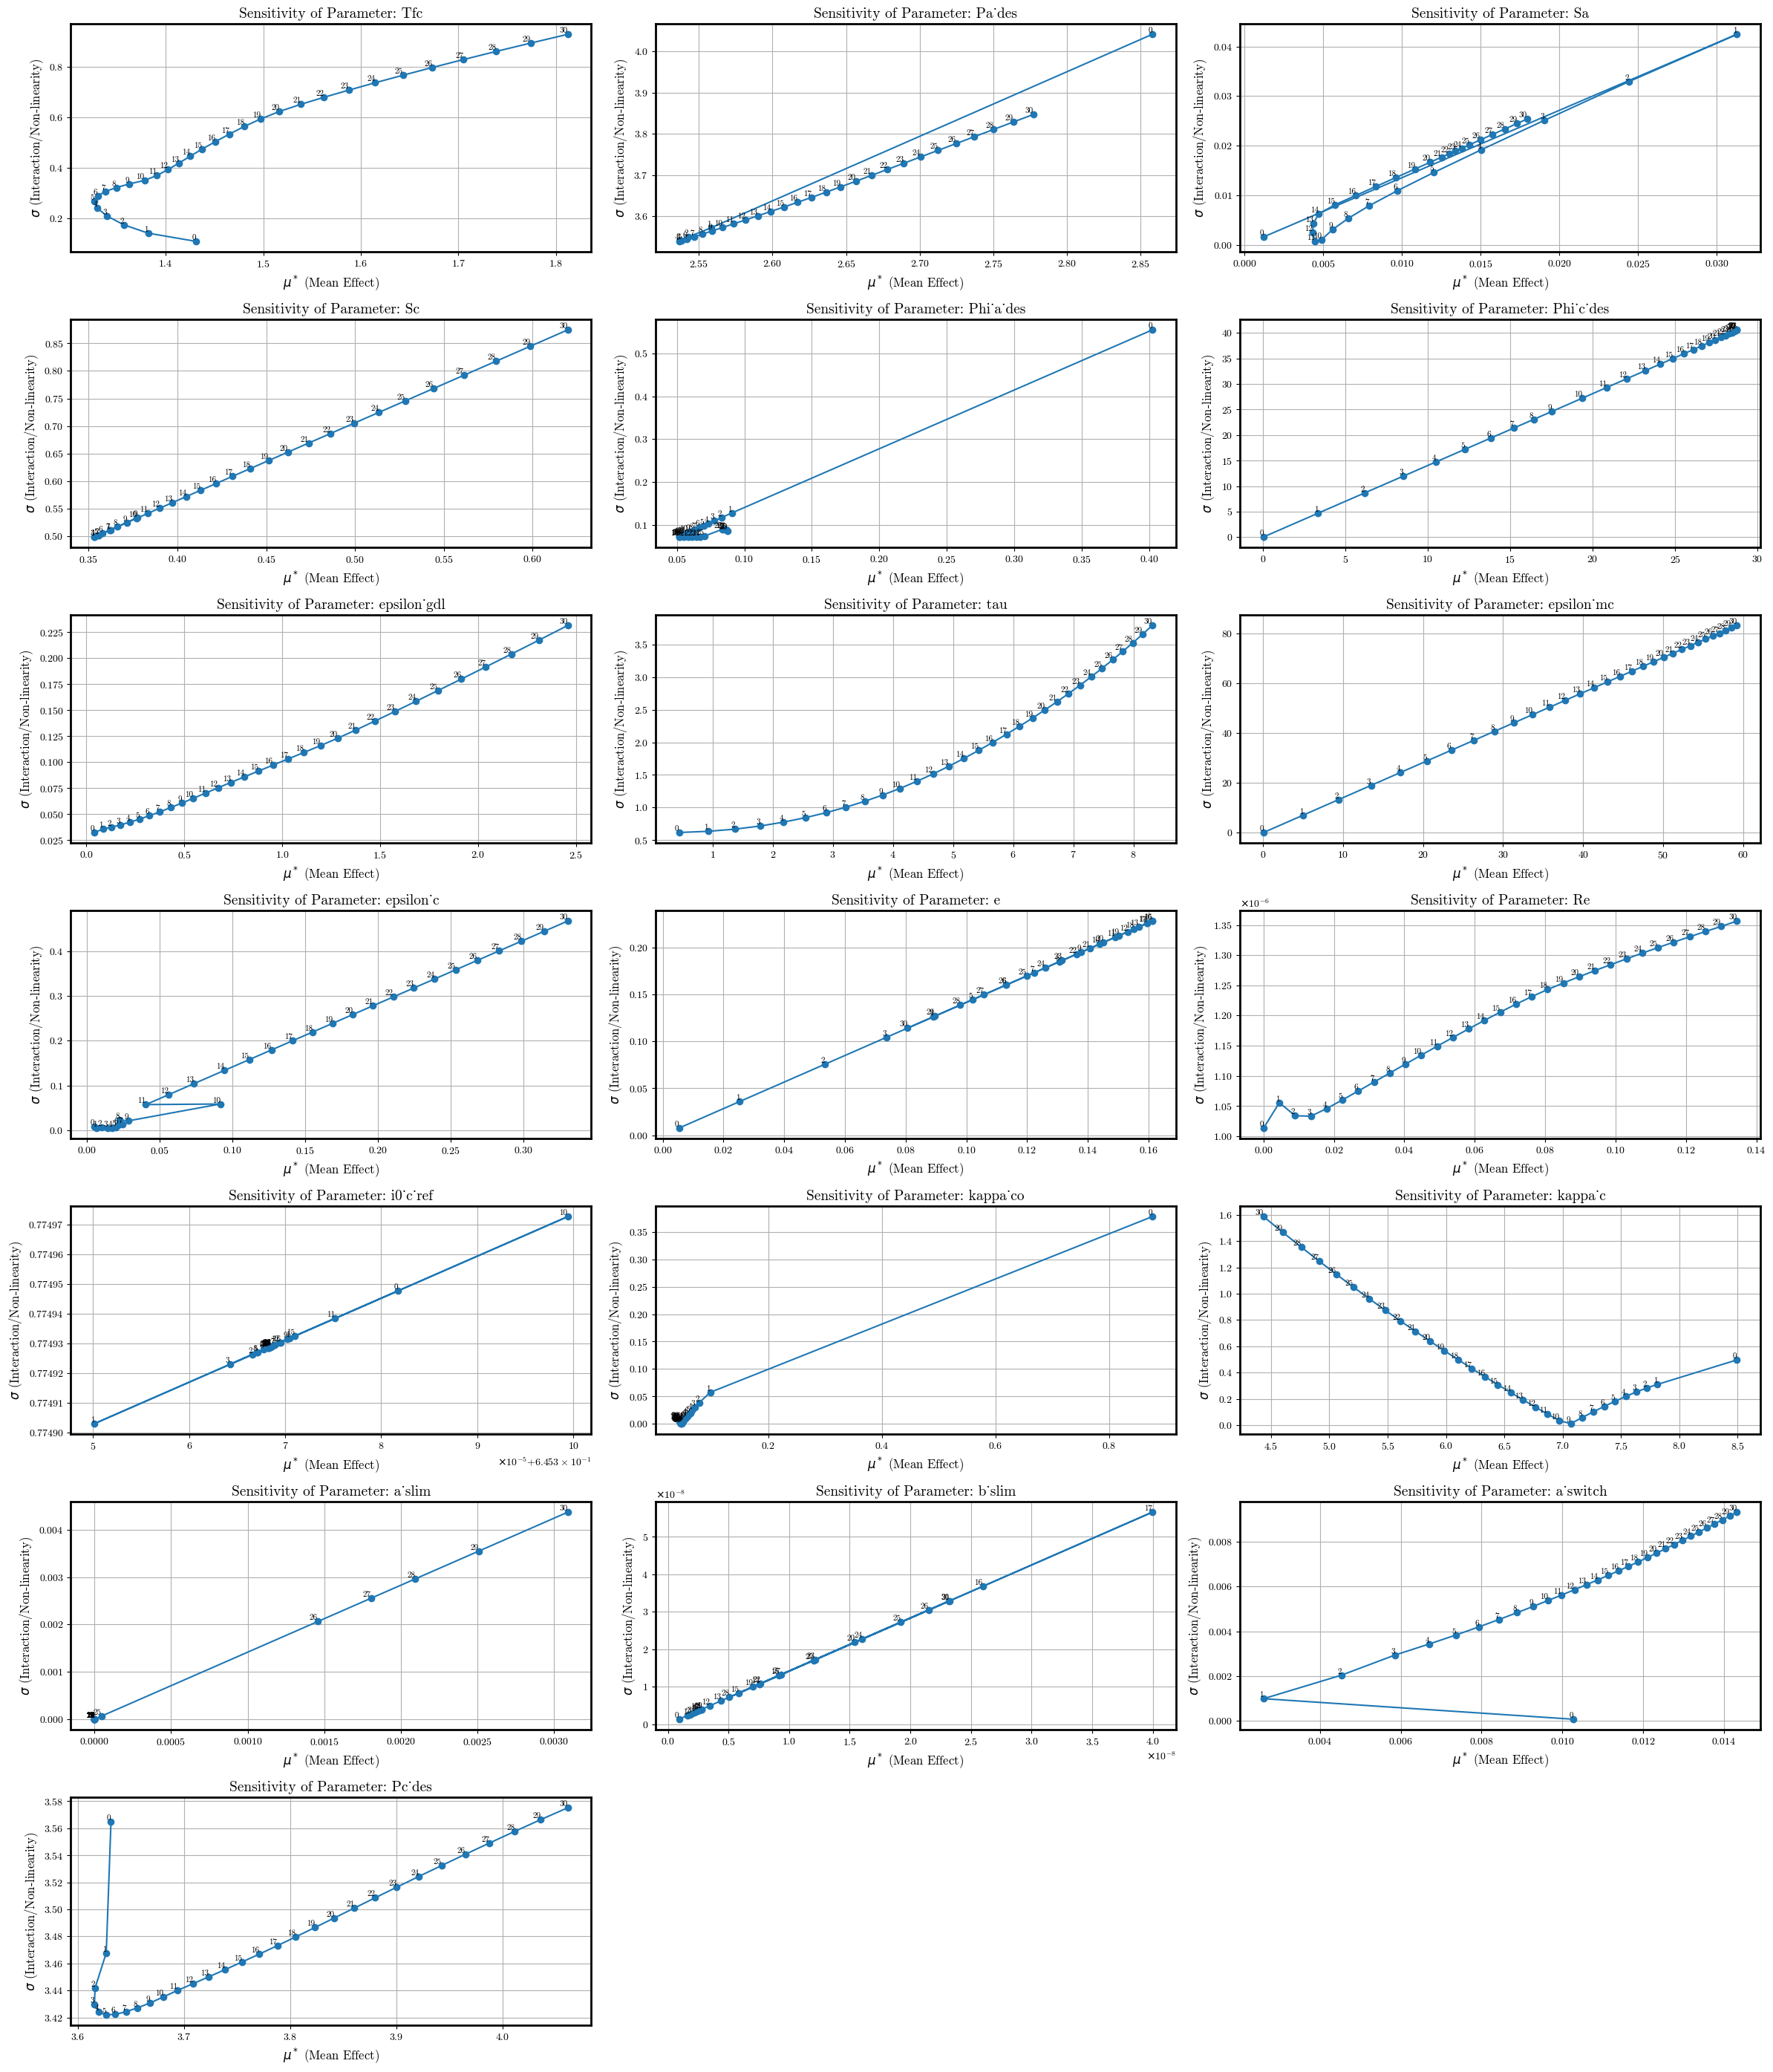

In [39]:
import matplotlib.pyplot as plt
import math

def plot_morris_sensitivity_entire_function(morris_all, problem, n_cols=3):
    """
    Plots the sensitivity of parameters based on morris_all results in subplots.
    
    Parameters:
        morris_all (list of dict): List containing the sensitivity analysis results.
        problem (dict): Dictionary containing problem information, including parameter names.
        n_cols (int): Number of columns in the subplot grid (default is 3).
    """
    params = problem['names']
    n_params = len(params)
    n_outputs = len(morris_all)

    # Calculate the number of rows needed based on number of columns
    n_rows = math.ceil(n_params / n_cols)

    # Create subplots with the calculated number of rows and columns
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(8 * n_cols, 4 * n_rows))

    # Flatten axes array for easier iteration
    axes = axes.flatten()

    # Loop through each parameter and create a plot in the corresponding subplot
    for param_idx, ax in enumerate(axes):
        if param_idx >= n_params:
            ax.axis('off')  # Hide empty subplots if there are fewer parameters than subplots
            continue

        mu_star_vals = []
        sigma_vals = []
        output_indices = []

        for output in morris_all:
            mu_star_vals.append(output['mu_star'][param_idx])
            sigma_vals.append(output['sigma'][param_idx])
            output_indices.append(output['output_index'])

        ax.plot(mu_star_vals, sigma_vals, marker='o', linestyle='-')
        
        for i, (mu, sigma) in enumerate(zip(mu_star_vals, sigma_vals)):
            ax.text(mu, sigma, str(output_indices[i]), fontsize=8, ha='right', va='bottom')

        ax.set_xlabel(r'$\mu^*$ (Mean Effect)', fontsize=12)
        ax.set_ylabel(r'$\sigma$ (Interaction/Non-linearity)', fontsize=12)
        ax.set_title(f'Sensitivity of Parameter: {params[param_idx]}', fontsize=14)
        ax.grid(True)

    # Adjust layout and add extra vertical space
    plt.subplots_adjust(hspace=0.4)  # Adjust this value to control the vertical space
    plt.tight_layout()
    plt.show()

plot_morris_sensitivity_entire_function(morris_all, problem)

C:\Users\dejvi\AppData\Local\Temp\ipykernel_15272\3706683639.py:29: UserWarning: Glyph 956 (\N{GREEK SMALL LETTER MU}) missing from font(s) cmr10.
  plt.tight_layout()
C:\Users\dejvi\AppData\Local\Temp\ipykernel_15272\3706683639.py:29: UserWarning: Glyph 963 (\N{GREEK SMALL LETTER SIGMA}) missing from font(s) cmr10.
  plt.tight_layout()
c:\Users\dejvi\Documents\GitHub\Sensitivity-Analysis-and-Surrogate-Modeling-of-PEM-Fuel-Cells\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 963 (\N{GREEK SMALL LETTER SIGMA}) missing from font(s) cmr10.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\dejvi\Documents\GitHub\Sensitivity-Analysis-and-Surrogate-Modeling-of-PEM-Fuel-Cells\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 956 (\N{GREEK SMALL LETTER MU}) missing from font(s) cmr10.
  fig.canvas.print_figure(bytes_io, **kw)


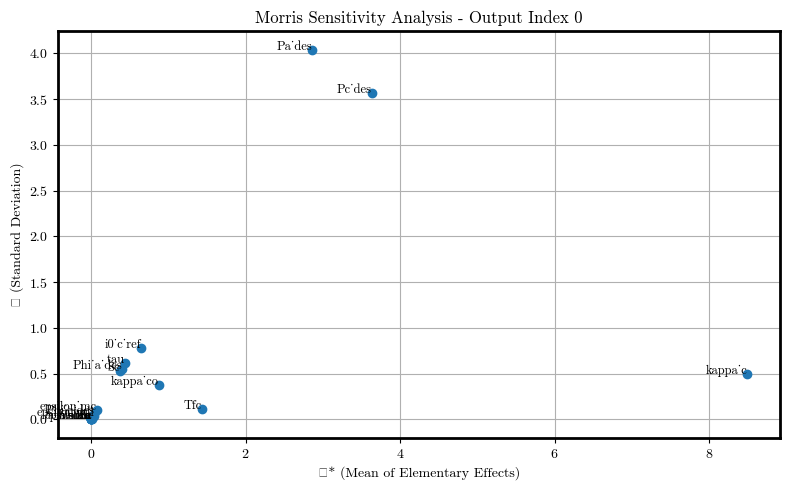

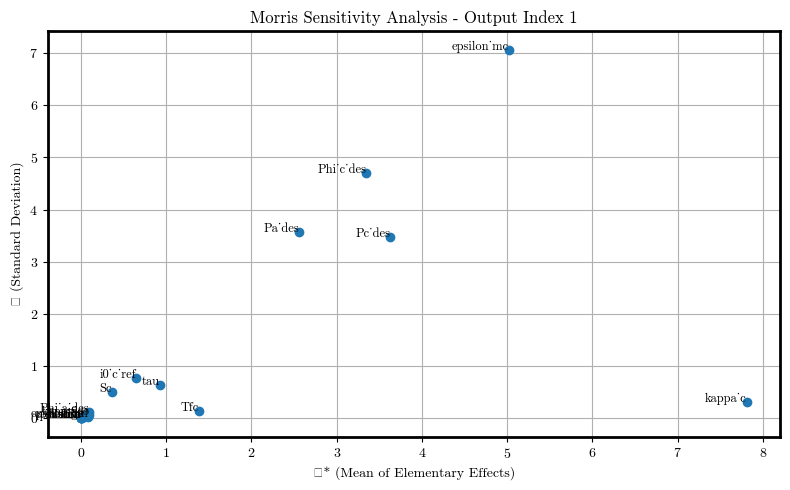

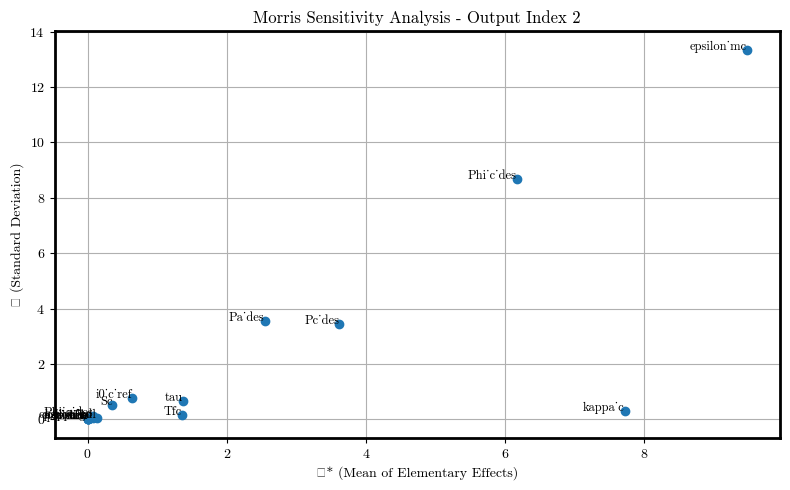

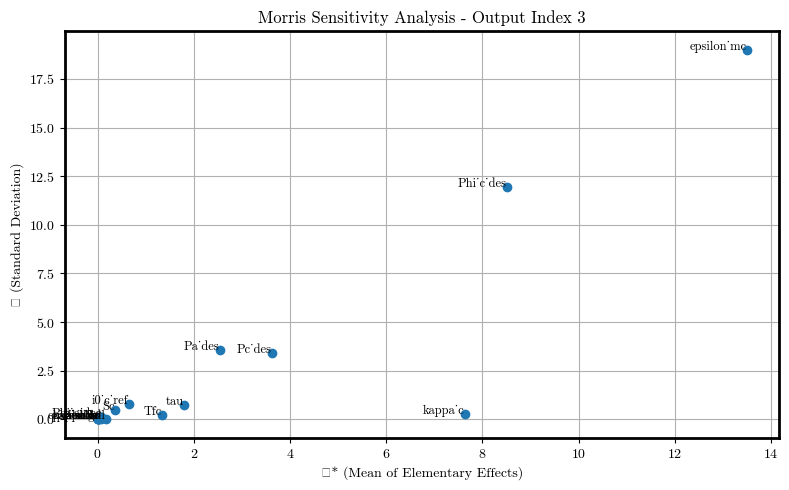

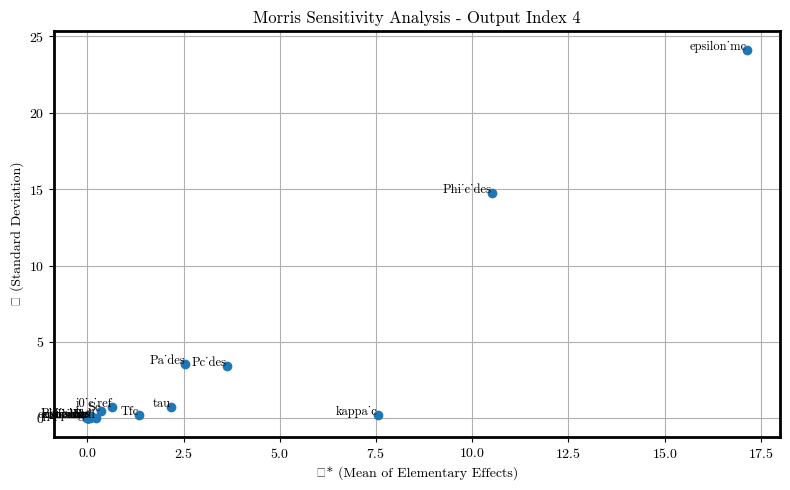

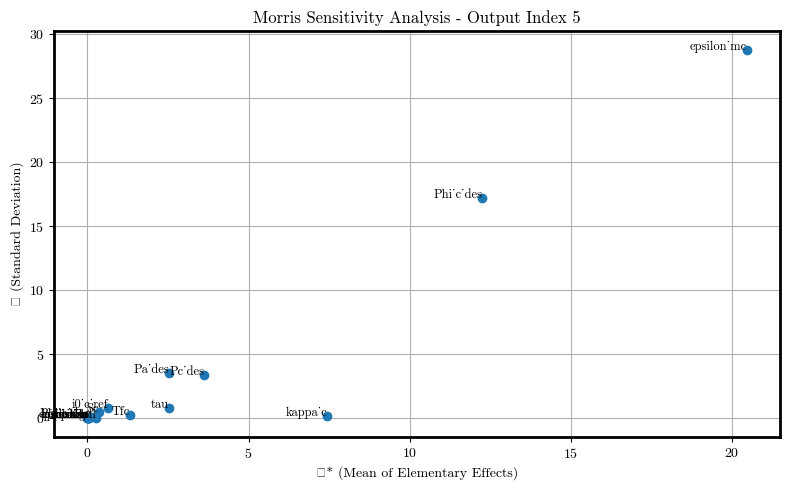

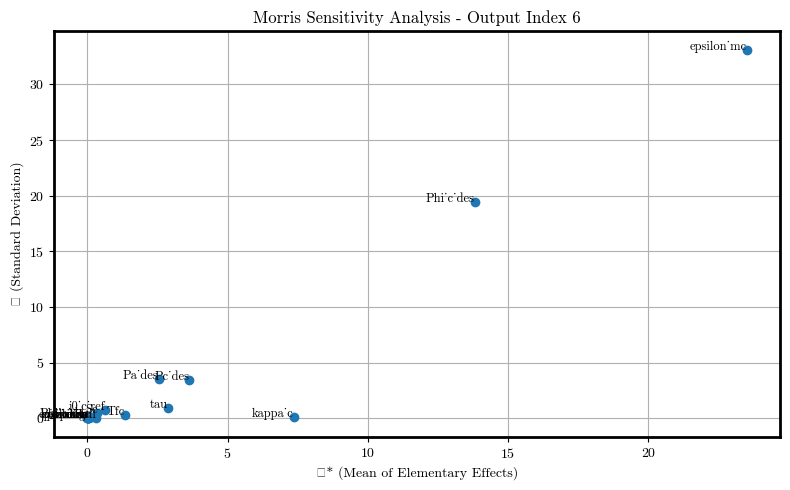

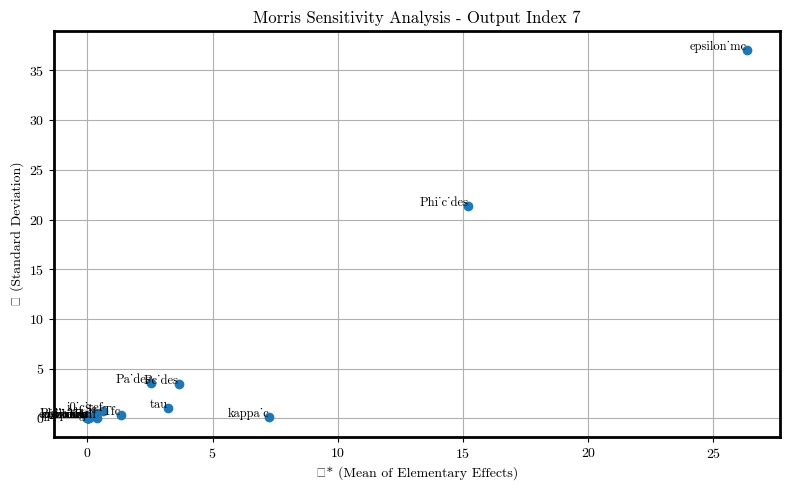

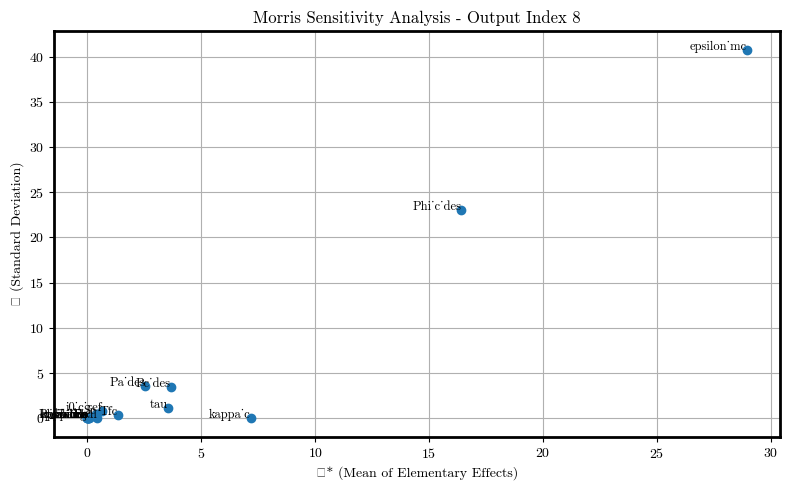

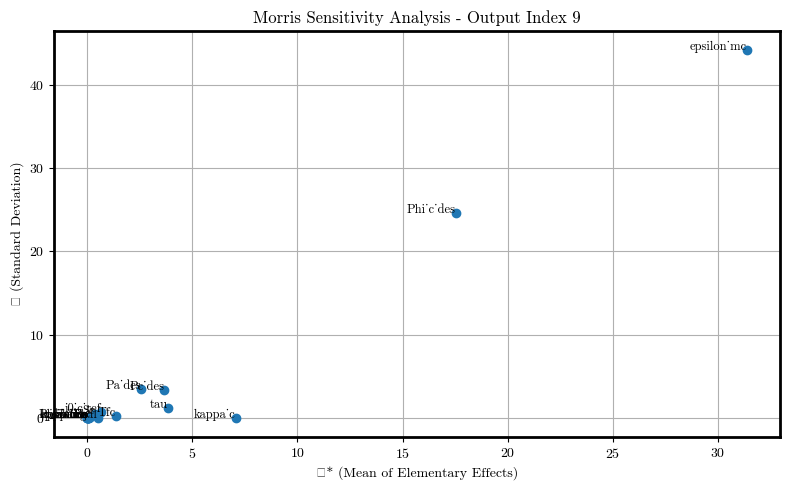

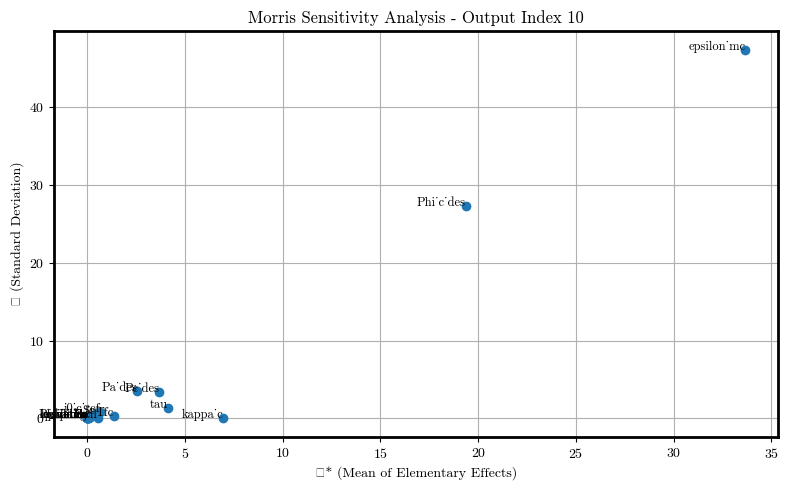

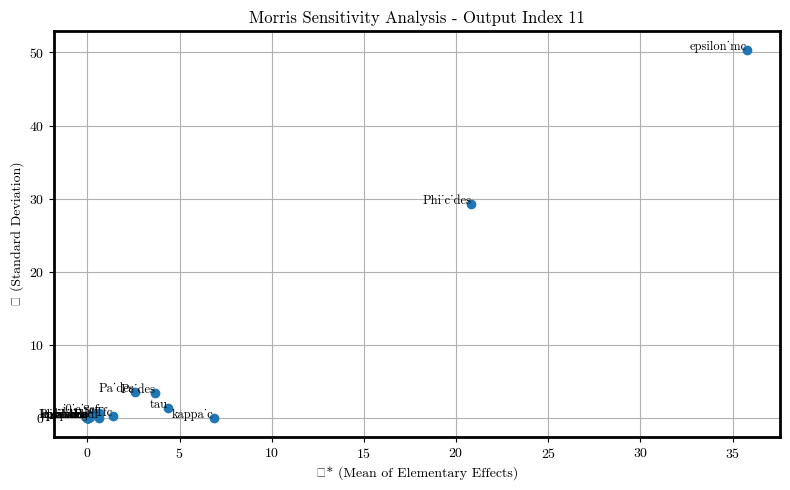

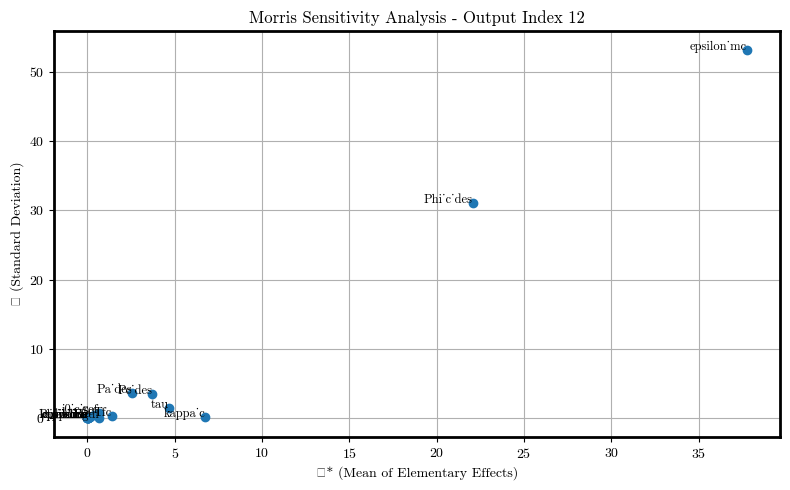

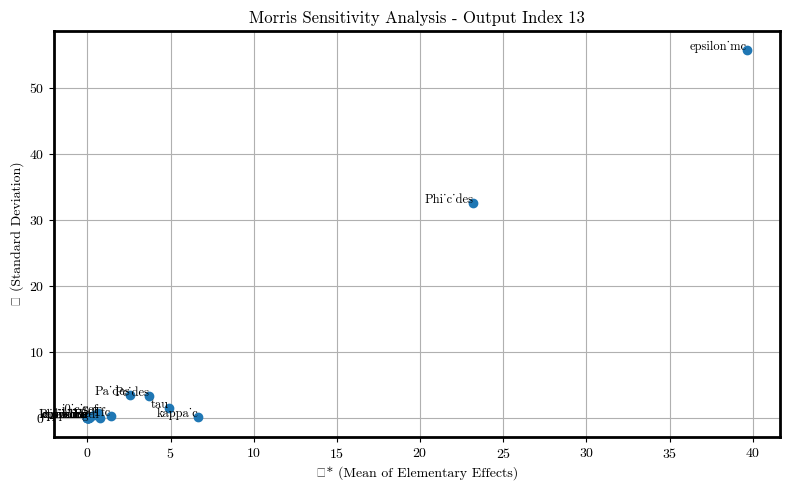

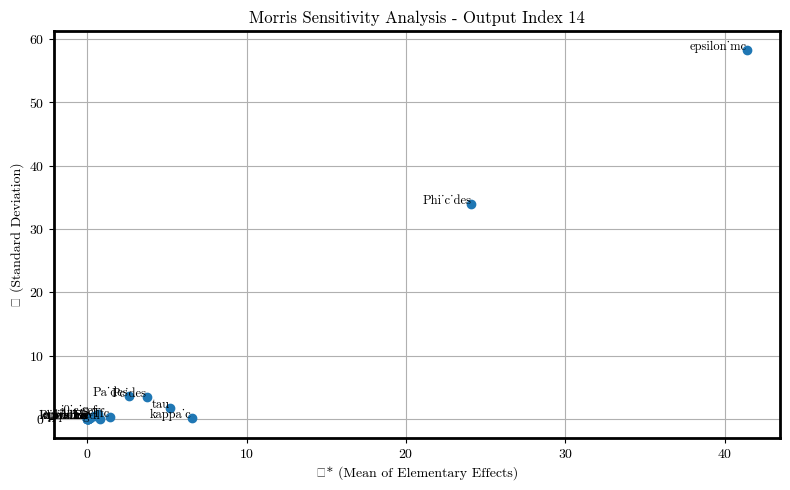

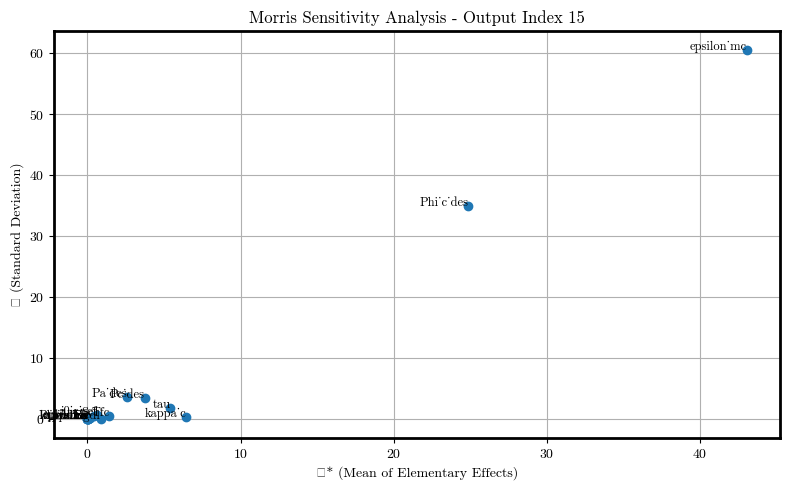

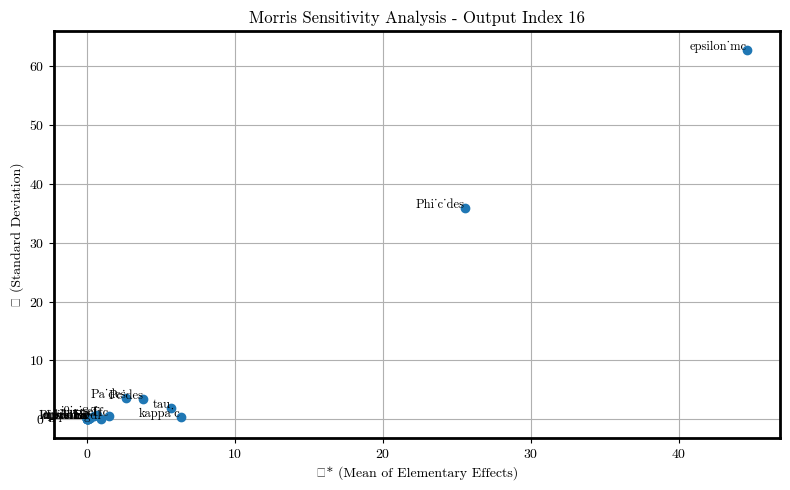

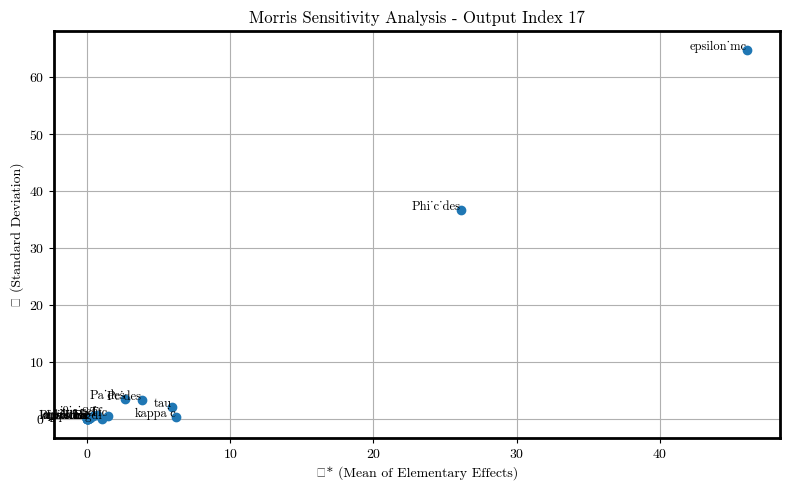

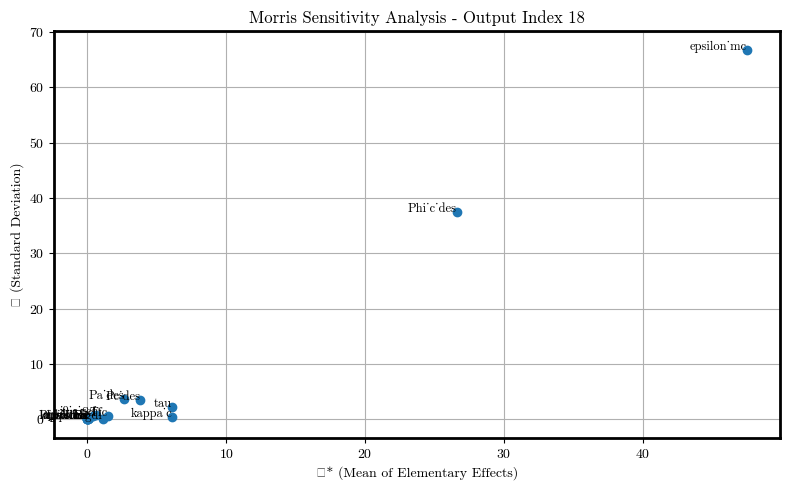

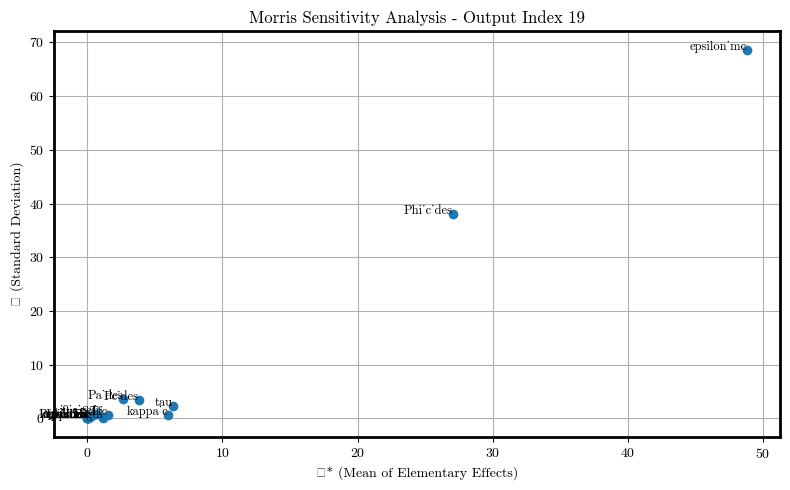

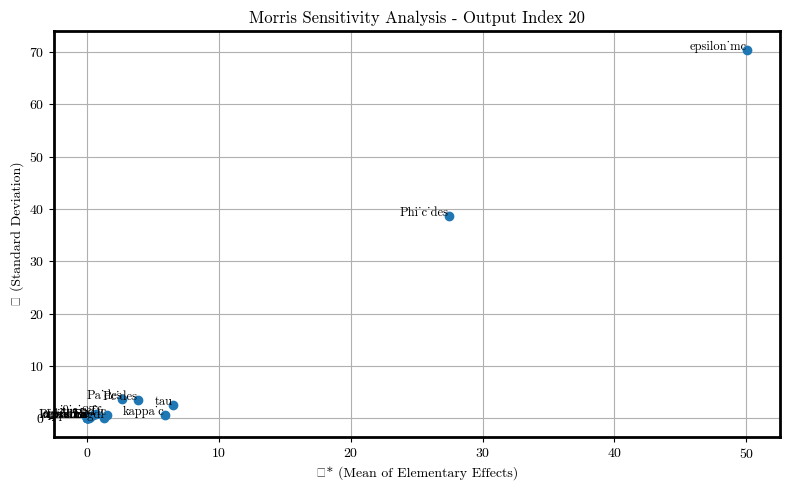

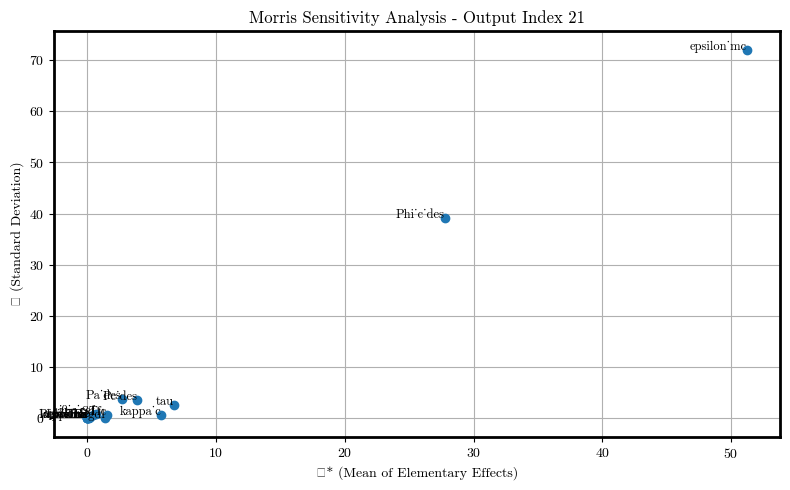

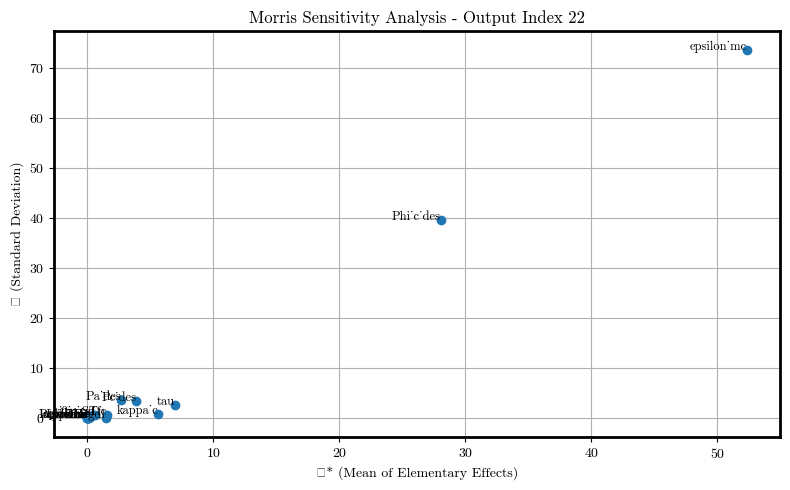

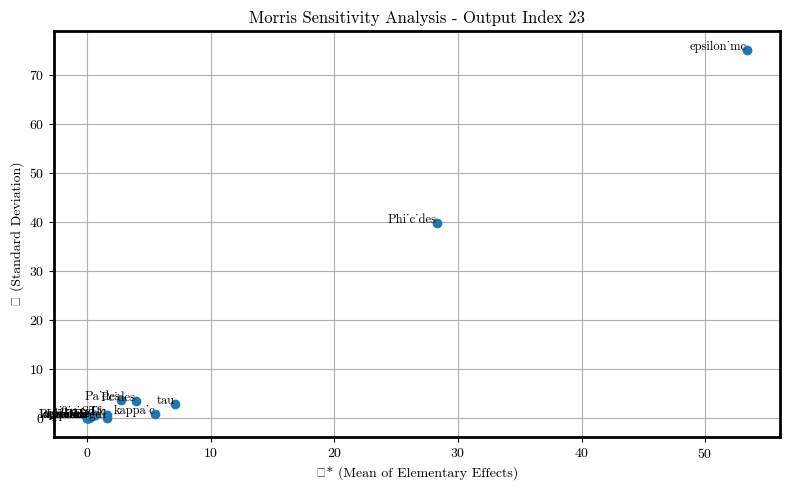

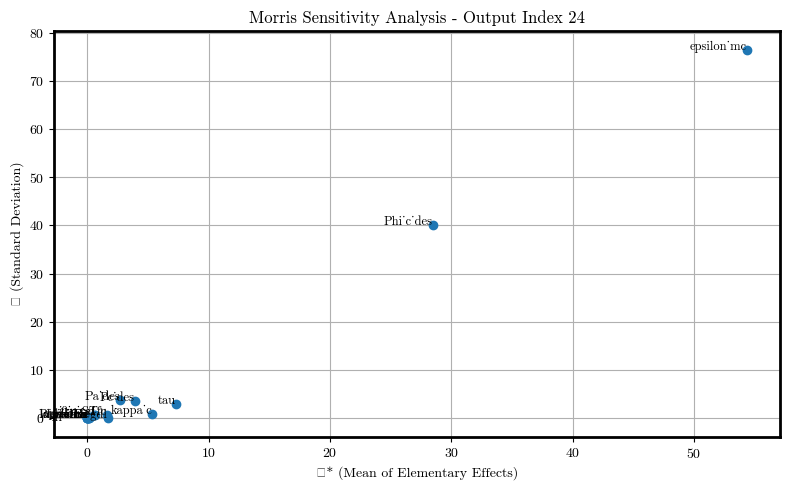

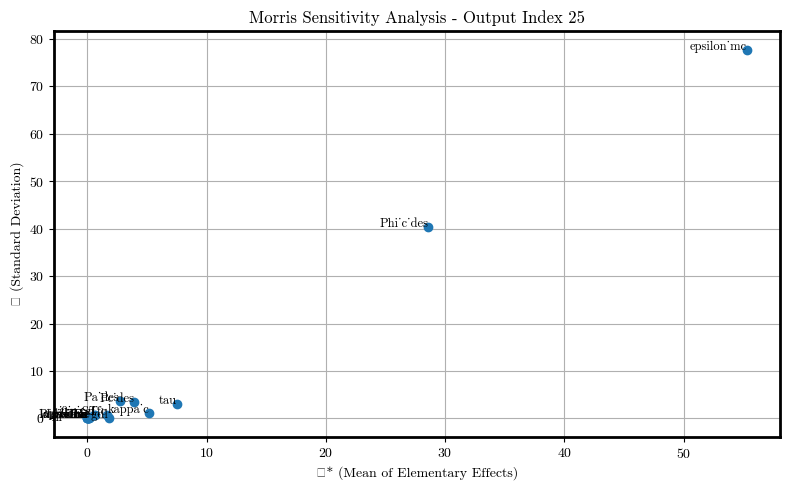

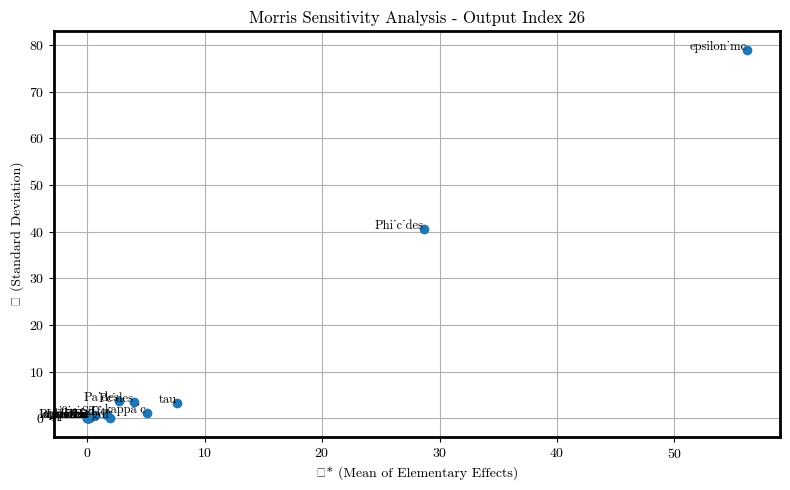

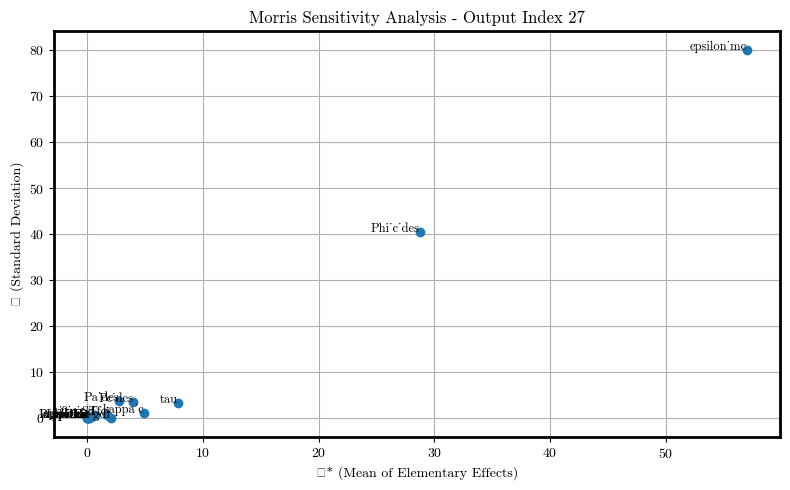

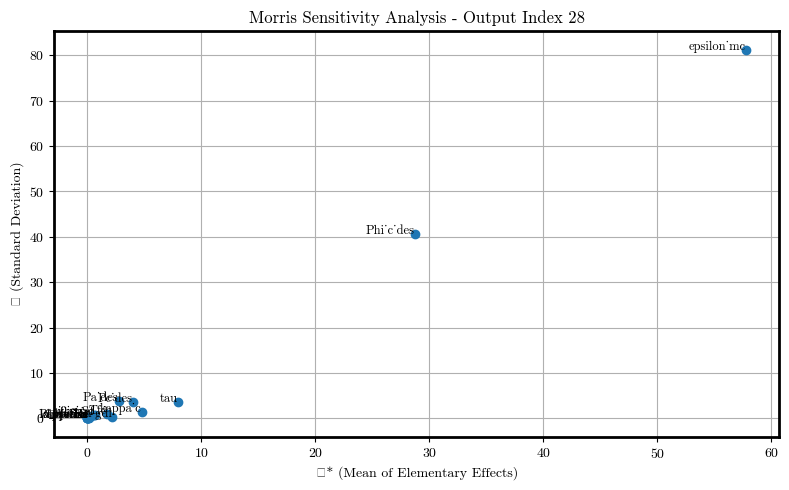

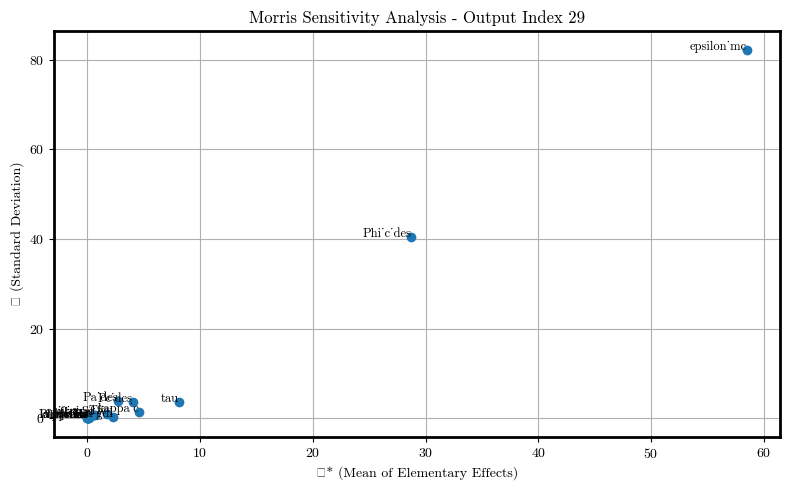

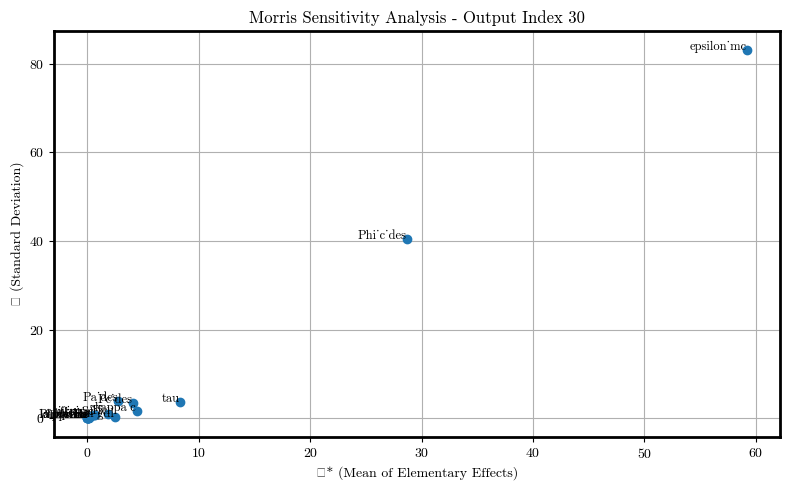

In [41]:
import matplotlib.pyplot as plt
import numpy as np

def plot_morris_sensitivity_per_index(morris_all, figsize=(8, 5)):
    """
    Plots Morris sensitivity analysis results.

    Parameters:
    - morris_all: list of dicts with keys 'mu_star', 'sigma', 'param', and 'output_index'
    - figsize: tuple, size of each plot
    """
    n_outputs = len(morris_all)

    for i in range(n_outputs):
        result = morris_all[i]
        mu_star = result['mu_star']
        sigma = result['sigma']
        param_names = result['param']

        plt.figure(figsize=figsize)
        plt.errorbar(mu_star, sigma, fmt='o', ecolor='gray', capsize=5)
        for j, param in enumerate(param_names):
            plt.text(mu_star[j], sigma[j], param, fontsize=9, ha='right')

        plt.title(f"Morris Sensitivity Analysis - Output Index {i}")
        plt.xlabel("μ* (Mean of Elementary Effects)")
        plt.ylabel("σ (Standard Deviation)")
        plt.grid(True)
        plt.tight_layout()
        plt.show()
plot_morris_sensitivity_per_index(morris_all)

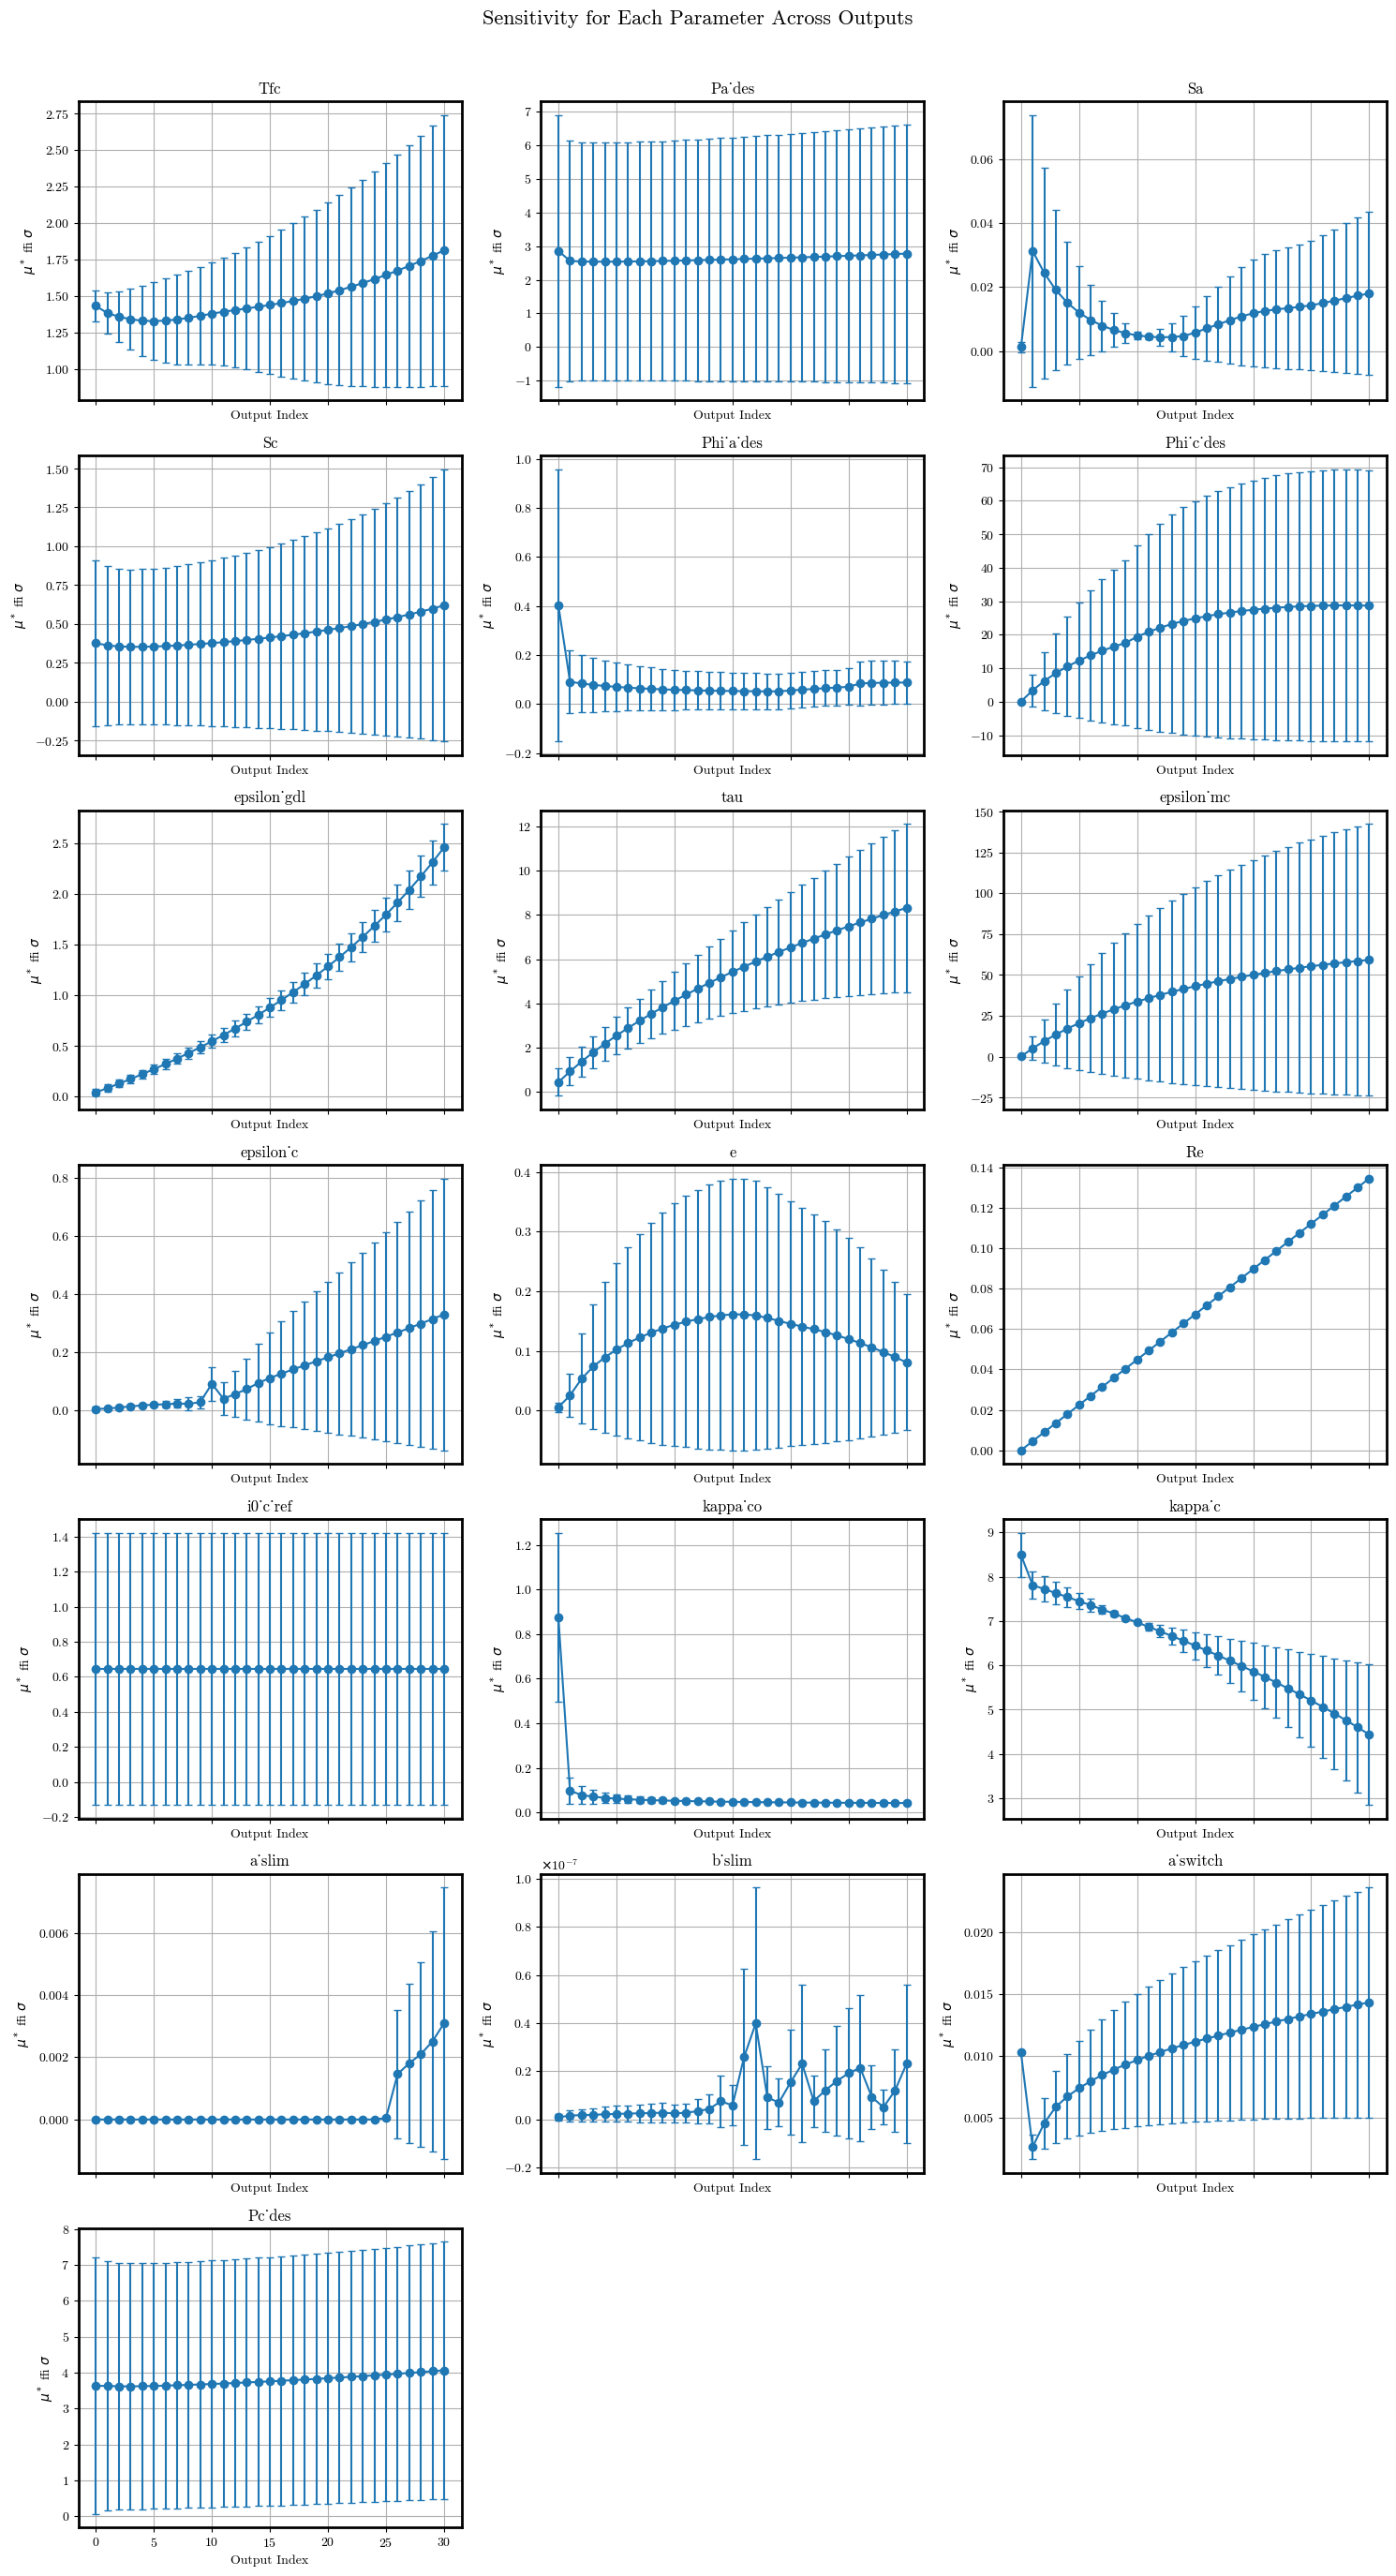

In [45]:
import matplotlib.pyplot as plt
import numpy as np

def plot_morris_grid(morris_all, params, n_cols=3):
    """
    Plot a grid of subplots showing sensitivity (mu_star ± sigma) for each parameter across outputs.

    Parameters:
    - morris_all: list of dicts with keys 'mu_star', 'sigma' (output of Morris analysis for each output index)
    - params: list of parameter names
    - n_cols: number of columns in subplot grid (default is 3)
    """
    n_params = len(params)
    n_outputs = len(morris_all)
    n_rows = int(np.ceil(n_params / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows), sharex=True)

    for i in range(n_params):
        ax = axes.flat[i]
        mu_star_vals = [out['mu_star'][i] for out in morris_all]
        sigma_vals = [out['sigma'][i] for out in morris_all]
        ax.errorbar(range(n_outputs), mu_star_vals, yerr=sigma_vals, fmt='-o', capsize=3)
        ax.set_title(params[i])
        ax.set_xlabel("Output Index")
        ax.set_ylabel(r"$\mu^*$ ± $\sigma$")
        ax.grid(True)

    # Remove unused axes
    for j in range(n_params, n_rows * n_cols):
        fig.delaxes(axes.flat[j])

    fig.suptitle("Sensitivity for Each Parameter Across Outputs", fontsize=16)
    fig.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

plot_morris_grid(morris_all, params=problem['names'])


In [47]:
import numpy as np
import pandas as pd

def summarize_morris_results(morris_all, problem):
    """
    Summarizes Morris sensitivity analysis across multiple outputs.

    Parameters:
    - morris_all: list of dicts with keys 'mu_star' (list of float) and 'param' (list of str)
    - problem: dict containing 'names' (list of parameter names)

    Returns:
    - df_summary: DataFrame with mean and std of mu_star across outputs, sorted by importance
    """
    params = problem['names']
    mu_star_matrix = np.array([output['mu_star'] for output in morris_all])

    mu_star_mean = mu_star_matrix.mean(axis=0)
    mu_star_std = mu_star_matrix.std(axis=0)

    df_summary = pd.DataFrame({
        'Parameter': params,
        'Mu*_mean': mu_star_mean,
        'Mu*_std': mu_star_std
    })

    df_summary = df_summary.sort_values(by='Mu*_mean', ascending=False).reset_index(drop=True)
    return df_summary

summarize_morris_results(morris_all, problem)

,Parameter,Mu*_mean,Mu*_std
0,epsilon_mc,3.870151e+01,1.685393e+01
1,Phi_c_des,2.115143e+01,8.383749e+00
2,kappa_c,6.368027e+00,1.052064e+00
3,tau,5.078022e+00,2.280934e+00
4,Pc_des,3.781720e+00,1.395214e-01
5,Pa_des,2.634612e+00,8.470505e-02
6,Tfc,1.485608e+00,1.413570e-01
7,epsilon_gdl,1.004912e+00,7.050314e-01
8,i0_c_ref,6.453695e-01,7.016649e-06
9,Sc,4.384667e-01,8.018837e-02
